In [1]:

!pip install wrds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 18.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0


In [3]:
import wrds

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm

import pandas_datareader.data as web

def get_factors(factors='CAPM',freq='daily'):

    if freq=='monthly':
        freq_label=''
    else:
        freq_label='_'+freq


    if factors=='CAPM':
        fama_french = web.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]


        df_factor = daily_data[['RF','Mkt-RF']]
    elif factors=='FF3':
        fama_french = web.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]

        df_factor = daily_data[['RF','Mkt-RF','SMB','HML']]
    elif factors=='FF5':

        fama_french = web.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]

        df_factor = daily_data[['RF','Mkt-RF','SMB','HML']]
        fama_french2 = web.DataReader("F-F_Research_Data_5_Factors_2x3"+freq_label, "famafrench",start="1921-01-01")
        daily_data2 = fama_french2[0]

        df_factor2 = daily_data2[['RMW','CMA']]
        df_factor=df_factor.merge(df_factor2,on='Date',how='outer')

    else:
        fama_french = web.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]

        df_factor = daily_data[['RF','Mkt-RF','SMB','HML']]
        fama_french2 = web.DataReader("F-F_Research_Data_5_Factors_2x3"+freq_label, "famafrench",start="1921-01-01")
        daily_data2 = fama_french2[0]

        df_factor2 = daily_data2[['RMW','CMA']]
        df_factor=df_factor.merge(df_factor2,on='Date',how='outer')
        fama_french = web.DataReader("F-F_Momentum_Factor"+freq_label, "famafrench",start="1921-01-01")
        df_factor=df_factor.merge(fama_french[0],on='Date')
        df_factor.columns=['RF','Mkt-RF','SMB','HML','RMW','CMA','MOM']
    if freq=='monthly':
        df_factor.index = pd.to_datetime(df_factor.index.to_timestamp())
    else:
        df_factor.index = pd.to_datetime(df_factor.index)



    return df_factor/100

def get_daily_wrds_multiple_ticker(tickers,conn):

    # Retrieve PERMNOs for the specified tickers
    permnos = conn.get_table(library='crsp', table='stocknames', columns=['permno', 'ticker', 'namedt', 'nameenddt'])
    permnos['nameenddt']=pd.to_datetime(permnos['nameenddt'])
    permnos = permnos[(permnos['ticker'].isin(tickers)) & (permnos['nameenddt']==permnos['nameenddt'].max())]
    # Extract unique PERMNOs
    permno_list = permnos['permno'].unique().tolist()
    print(permno_list)

    # Query daily stock file for the specified PERMNOs
    query = f"""
        SELECT permno, date, ret, retx, prc
        FROM crsp.dsf
        WHERE permno IN ({','.join(map(str, permno_list))})
        ORDER BY date
    """
    daily_returns = conn.raw_sql(query, date_cols=['date'])
    daily_returns = daily_returns.merge(permnos[['permno', 'ticker']], on='permno', how='left')
    # Pivot data to have dates as index and tickers as columns
    daily_returns = daily_returns.pivot(index='date', columns='ticker', values='ret')
    daily_returns=daily_returns[tickers]



    return daily_returns



def get_permnos(tickers,conn):

    # Retrieve PERMNOs for the specified tickers
    permnos = conn.get_table(library='crsp', table='stocknames', columns=['permno', 'ticker', 'namedt', 'nameenddt'])
    permnos['nameenddt']=pd.to_datetime(permnos['nameenddt'])
    permnos = permnos[(permnos['ticker'].isin(tickers)) ]




    return permnos

# Multi-factor models


---

**🎯 Learning Objectives**

By the end of this chapter, you should be able to:



1. **Understand why investors move beyond CAPM.**  
   Explain how adding multiple systematic factors (size, value, profitability, investment, momentum, etc.) sharpens alpha measurement, improves risk control, and better reflects real‐world return drivers.  

2. **Estimate factor betas with a time-series regression.**  
   Learn to regress an asset’s excess returns on a panel of factor returns, interpret coefficients as exposures, and judge statistical reliability.  

3. **Translate betas into economic insight through variance decomposition.**  
   Decompose each asset’s total variance into contributions from individual factors and idiosyncratic noise, revealing which risks truly matter.  

4. **Build cleaner covariance matrices using a factor structure.**  
   Combine factor loadings with the factor covariance matrix and asset-specific variances to obtain a stable, low-dimensional estimate suitable for portfolio optimization.  

5. **Apply multi-factor analysis to real portfolios and ETFs.**  
   Perform step-by-step alpha/beta evaluation of momentum ETFs, ranking funds on both skill (alpha) and risk profile.  

6. **Attribute portfolio risk when holdings change.**  
   Project how reallocating capital between strategies alters overall volatility, using factor exposures rather than naïve variance estimates.  

7. **Contrast top-down versus bottom-up factor measurement.**  
   Weigh the pros and cons of estimating betas from portfolio returns versus aggregating betas of individual holdings.  

8. **Explore the characteristic-based (cross-sectional) alternative.**  
   See how pricing firm-level attributes with cross-sectional regressions yields “characteristic-implied” returns and characteristic-adjusted performance.  



---







So far we have focused on the market as our single factor.

In practice it is standard to use factor models with many factors

Additional factors

- soak up risk making measure of alpha easier
- Difference out other sources of expected excess returns that are easy to get access to
- Allows for better risk management


We deal with this, by simply adding more factors to our model. Say we now have $m$ different factors

$$r_t^i=b_{i,1}f_t^1+b_{i,2}f_t^2+b_{i,3}f_t^3+...+b_{i,m}f_t^m+\epsilon_{i,t}$$


Where $b_{i,j}$ measures the exposure of asset $i$ to factor $j$

IF we stack these exposures in a m by 1 vector $B_i=[b_{i,1},b_{i,2},...b_{i,M}]$ and the factors in a m by 1 vector $F_t=[f^1_t,f^2_t,...,f^m_t]$ we can write this in matrix notation

$$r_t^i=B_i@F_t+u_{i,t}$$


As before we can also stack the individual returns :

$$R_t=B@F_t+U_t$$

where

-  $R_t$ is a n by 1 vector with the excess returns of the n assets
-  $B$ is n by m matrix where each row has the exposure of an asset with respect to each M factor and each column has the exposures of the different assets with respect to a particular factor
- $U_t$ as before is a n by 1 vector with the residual risk of each asset







**"Endogenous" Benchmarking**

* it is common for large portfolio allocators to set benchmarks for the managers that they allocate to

* The most common benchmark is simply returns of the S&P500 which is almost the same thing as the returns of the market portfolio ( large caps dominate the returns of any market-cap portfolio)

* You might also have endogenous benchmarks

* Use a set of Factors F and estimate $r^b_t=\sum \beta_j F_{j,t}$

* I.e use as a bechmark the multifactor combination that best replicates the portfolio.

* typically this is not done contractually but implicitly: You will allocate to the different funds based on their alpha

* Captures the idea that one should pay different prices for alpha (very hard to get) and beta( easier, the gains are in implementation)





## Estimating a multi-factor model: The Time-series approach

We start with the factors and estimate the betas using time-series data

This works particularly well when the factors are excess returns themselves

For each asset We run a tim-series regression with the excess returns of the asset as the the dependent variable and the excess returns on the factors as the independent variables

## Application

What do you get when you invest in a Momentum ETF?

1. Get daily return data on the larger ETFs claiming to implement the momentum factor
2. Get factors excess returns: Market, Size (SMB), Value (HML), Profitability (RMW), Investment (CMA) , and Momentum (MOM)
3. Run a time series regression for each ETF on the factors
4. Look at alphas and betas

In [3]:
tickers = ["MTUM", "SPMO", "XMMO", "IMTM", "XSMO", "PDP", "JMOM", "DWAS", "VFMO", "XSVM", "QMOM"]
conn=wrds.Connection()
# Get daily returns for the specified tickers
df_ETF=get_daily_wrds_multiple_ticker(tickers,conn)
# Get daily factors
df_factor=get_factors('FF6','daily')
# Align the dataframes
df_ETF, df_factor = df_ETF.align(df_factor, join='inner', axis=0)
# Subtract risk-free rate from ETF returns
df_ETF=df_ETF.subtract(df_factor['RF'],axis=0)

Enter your WRDS username [root]:am16634
Enter your password:··········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
[13512, 13851, 15161, 15725, 17085, 17392, 17622, 90621, 90622, 90623, 91876]


/tmp/ipython-input-1923617899.py:41: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  fama_french = web.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
/tmp/ipython-input-1923617899.py:45: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  fama_french2 = web.DataReader("F-F_Research_Data_5_Factors_2x3"+freq_label, "famafrench",start="1921-01-01")
/tmp/ipython-input-1923617899.py:50: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  fama_french = web.DataReader("F-F_Momentum_Factor"+freq_label, "famafrench"

In [5]:


import statsmodels.api as sm

X = df_factor.drop(columns=['RF'])
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = df_ETF["QMOM"]
X=X[y.isna()==False]
y=y[y.isna()==False]
model = sm.OLS(y, X).fit(dropna=True)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   QMOM   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     1217.
Date:                Tue, 18 Nov 2025   Prob (F-statistic):               0.00
Time:                        14:03:26   Log-Likelihood:                 7764.3
No. Observations:                2284   AIC:                        -1.551e+04
Df Residuals:                    2277   BIC:                        -1.547e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.184e-05      0.000      0.129      0.8

In [9]:
Results=pd.DataFrame([],index=tickers,columns=X.columns)
for ticker in tickers:
    y = df_ETF[ticker]
    X = df_factor.drop(columns=['RF'])
    X = sm.add_constant(X)
    X=X[y.isna()==False]
    y=y[y.isna()==False]
    model = sm.OLS(y, X).fit(dropna=True)
    Results.loc[ticker,:]=model.params
    Results.at[ticker,'t_alpha']=model.tvalues['const']
    Results.at[ticker,'ivol']=model.resid.std()*252**0.5
    Results.at[ticker,'Sample size']=y.shape[0]/252

Results.loc[:,'const']=Results.loc[:,'const']*252
Results.rename(columns={'const':'alpha'},inplace=True)
Results=Results[['alpha','t_alpha','Mkt-RF','SMB','HML','RMW','CMA','MOM','ivol','Sample size']]
Results

,alpha,t_alpha,Mkt-RF,SMB,HML,RMW,CMA,MOM,ivol,Sample size
MTUM,-0.007282,-0.447992,1.024866,-0.105147,-0.057269,-0.127639,-0.027402,0.326001,0.055398,11.690476
SPMO,0.018139,0.771493,1.013642,-0.158997,-0.0495,-0.02651,0.076532,0.255095,0.071108,9.210317
XMMO,0.009412,0.495812,1.040181,0.337055,0.041031,0.030028,-0.106015,0.199402,0.084288,19.805556
IMTM,-0.033995,-1.061967,0.802487,-0.013357,0.056833,-0.132231,0.12593,0.118384,0.100628,9.944444
XSMO,-0.012837,-0.642703,0.98423,0.860196,0.191092,0.100151,-0.092922,0.16577,0.088681,19.805556
PDP,-0.015907,-1.058717,1.054893,0.142871,-0.00844,-0.083458,-0.184182,0.252133,0.063257,17.817460
JMOM,0.004179,0.206044,0.963246,0.012659,-0.064674,-0.07884,-0.066537,0.10529,0.053913,7.123016
DWAS,-0.010497,-0.505913,1.088422,1.076072,0.231479,-0.225859,-0.0794,0.400343,0.072930,12.428571
VFMO,0.011059,0.551059,1.030116,0.449151,0.185205,-0.220818,-0.061642,0.396458,0.052366,6.861111
XSVM,-0.004173,-0.224534,0.932703,0.983764,0.528055,0.329123,0.194403,-0.0564,0.082527,19.805556


How should we evaluate these funds?

Which fund is "better"? Is it all about alpha in this case?

What are other things that we should be looking at?

Is this table providing a fair comparison across funds?


## Performance Attribution


- We can use factor models to decompose a manager strategy

- What explains their returns?

- What tilts they have?  What kind of stocks they like?


### Application: What does Cathie Wood  Likes ?



![Cathie Wood](https://github.com/amoreira2/Fin418/blob/main/assets/plots/CW_image.jfif?raw=1)

Cathie Wood is a renowned stock-picker and the founder of ARK Invest, which manages around 60 billion in assets and invests in innovative technologies such as self-driving cars and genomics. She gained fame for her success in the male-dominated world of investing, her persuasive investment arguments, and her proven track record in the stock market. Prior to founding ARK Invest, she gained experience at The Capital Group, Jennison Associates, and AllianceBernstein, and co-founded Tupelo Capital Management, a hedge fund. Wood is known for her unconventional investment strategies and her advocacy for investing in disruptive technologies, which has garnered her a large following in the investing world. Her estimated net worth is around $250 million.


Citations:
https://www.nytimes.com/2021/08/22/business/cathie-wood-ark-stocks.html




np.float64(0.2688111096710979)

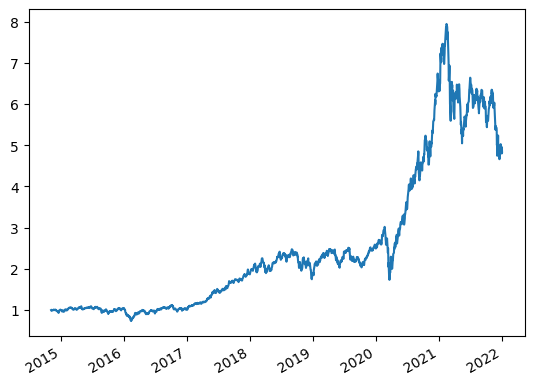

In [24]:
df=pd.read_pickle('https://raw.githubusercontent.com/amoreira2/Fin418/main/assets/data/df_WarrenBAndCathieW.pkl')
_temp=df.drop(['BRK'],axis=1).dropna()
# select the columns to use as factors
Factors=_temp.drop(['RF','ARKK'],axis=1)
ArK=_temp.ARKK-_temp.RF
(ArK+1).cumprod().plot()
ArK.mean()*252

# _temp=df.drop(['ARKK'],axis=1).dropna()
# # select the columns to use as factors
# Factors=_temp.drop(['RF','BRK'],axis=1)
# BrK=_temp.BRK-_temp.RF
# (BrK+1).cumprod().plot()
# BrK.mean()*252


What are these factors?

* HML is the value strategy that buys high book to market firms and sell low book to market firms

* SMB is a size strategy that buys firms with low market capitalization and sell firms with high market capitalizations

* RmW is the strategy that buys firms with high gross profitability and sell firms with low gross profitability

* CmA is the strategy that buys firms that are investing little (low CAPEX) and sell firms that are investing a lot (high CAPEX)

* MOM is the momentum strategy that buy stocks that did well in the last 12 months and short the ones that did poorly


We will discuss more later

for now just think of them as important trading strategies that practicioners know

<Axes: >

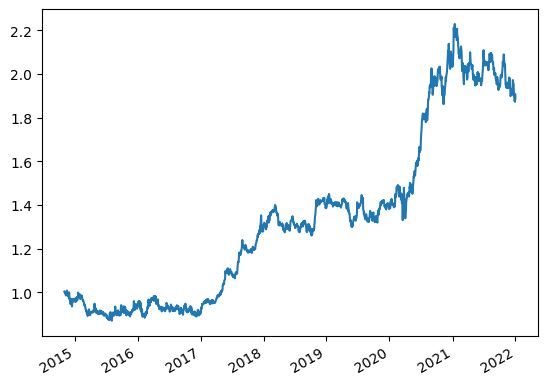

In [27]:

x= sm.add_constant(Factors*252)
y= ArK*252
results= sm.OLS(y,x).fit()
results.summary()



- How much can we explain of ARKK return behavior?

- What kind of stocks CW likes?

- How much of her portfolio variance comes from market exposure alone?

- How much comes from being negative value?

- If you were to construct a replicating portfolio of her fund what would be the volatility of your residual risk?

- Look at the return pattern for the hedged portfolio--when she earned her alpha? Is it smooth? What questions come up?





## Bottom up: from assets factor risk to portfolio factor risk



Above we estimated fund factor exposures by looking at how the fund co-move with the different factors

An alternative is to look through the fund and compute asset factor loadings and from them compute the fund factor loadings

Consider portfolio with weights  $X$ that earns excess returns $r=X@R$ where R is the vector of asset excess returns.

Asset's excess returns satisfy a factor model

$$R=A+B@F+U$$

then the portfolio satisfies

$$r=X@R=X@(A+B@F+U)=X@A+X@B@F+X@U$$

In scalar notation this is simply

$$r=\sum_i x_i r_i=\sum_i x_i\alpha_i+ \sum_j \sum_i x_i \beta_{i,j}f_j+\sum_i x_i\epsilon_i$$

So the portfolio exposure to factor j is simply the dollar-weighted average of the asset betas

$$\beta_{p,j}=\sum_i x_i \beta_{i,j}$$

- For portfolios with high turnover, this approach will lead to better measurement of factor risk
- For portfolios that do not trade, then measuring individual asset betas might introduce unnecessary noise and extra work


In [ ]:
import pandas as pd

date1='2014-12-31'
date2='2015-12-31'
date3='2016-12-31'
# Define the portfolio data
portfolio_data1 = {
    'date': [date1,date1,date1,date1,date1],
    'ticker': ['AAPL', 'GOOGL', 'MSFT','NVDA','AMZN'],
    'weight': [0.2,0.2, 0.2,0.2,0.2]
}

portfolio_data2 = {
    'date': [date2,date2,date2,date2],
    'ticker': ['COST', 'WMT', 'TGT','KR'],
    'weight': [0.25,0.25, 0.25,0.25]
}
# Concatenate the two dataframes
portfolio_df1 = pd.DataFrame(portfolio_data1)
portfolio_df2 = pd.DataFrame(portfolio_data2)

# Generate monthly dates from date1 to date2 and from date2 to now
date_range1 = pd.date_range(start=date1, end=date2, freq='B')
date_range2 = pd.date_range(start=date2, end=date3, freq='B')

# Create monthly dataframes for each portfolio
monthly_portfolio1 = pd.DataFrame(
    [(date, ticker, weight) for date in date_range1 for ticker, weight in zip(portfolio_df1['ticker'], portfolio_df1['weight'])],
    columns=['date', 'ticker', 'weight']
)
monthly_portfolio2 = pd.DataFrame(
    [(date, ticker, weight) for date in date_range2 for ticker, weight in zip(portfolio_df2['ticker'], portfolio_df2['weight'])],
    columns=['date', 'ticker', 'weight']
)

# Combine the monthly dataframes
final_portfolio_df = pd.concat([monthly_portfolio1, monthly_portfolio2], ignore_index=True)

# import ace_tools as tools
# tools.display_dataframe_to_user(name="Portfolio Monthly Weights", dataframe=final_portfolio_df)

final_portfolio_df

,date,ticker,weight
0,2014-12-31,AAPL,0.20
1,2014-12-31,GOOGL,0.20
2,2014-12-31,MSFT,0.20
3,2014-12-31,NVDA,0.20
4,2014-12-31,AMZN,0.20
...,...,...,...
2353,2016-12-29,KR,0.25
2354,2016-12-30,COST,0.25
2355,2016-12-30,WMT,0.25
2356,2016-12-30,TGT,0.25


In [ ]:
tickers = final_portfolio_df.ticker.unique().tolist()
#conn=wrds.Connection()
# Get daily returns for the specified tickers
df_stocks=get_daily_wrds_multiple_ticker(tickers,conn)
# Get daily factors
df_factor=get_factors('FF6','daily')
df_factor=df_factor.dropna()
# Align the dataframes

# Subtract risk-free rate from ETF returns
df_stocks=df_stocks.subtract(df_factor['RF'],axis=0)
df_stocks

[10107, 14593, 16678, 49154, 55976, 84788, 86580, 87055, 90319]


ticker,AAPL,GOOGL,MSFT,NVDA,AMZN,COST,WMT,TGT,KR
1928-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2024-11-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df=df_stocks.stack()
df.name='eret'
df=final_portfolio_df.merge(df,left_on=['date','ticker'],right_index=True,how='left')
df

,date,ticker,weight,eret
0,2014-12-31,AAPL,0.20,-0.019019
1,2014-12-31,GOOGL,0.20,-0.008631
2,2014-12-31,MSFT,0.20,-0.012123
3,2014-12-31,NVDA,0.20,-0.015710
4,2014-12-31,AMZN,0.20,0.000161
...,...,...,...,...
2353,2016-12-29,KR,0.25,-0.002605
2354,2016-12-30,COST,0.25,-0.006340
2355,2016-12-30,WMT,0.25,-0.002031
2356,2016-12-30,TGT,0.25,-0.005380


## TOP DOWN Approach



For comparison lets estimate this fund factor exposure using the top down approach

Lets construct the portfolio return and then run the multi-factor regression

In [ ]:
fund_return=df.groupby('date').apply(lambda x: (x['eret']*x['weight']).sum() )
df_factor, fund_return = df_factor.align(fund_return, join='inner', axis=0)

In [ ]:
y=fund_return.copy()
X = df_factor.drop(columns=['RF'])
X = sm.add_constant(X)
X=X[y.isna()==False]
y=y[y.isna()==False]
model = sm.OLS(y, X).fit(dropna=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     94.64
Date:                Thu, 16 Jan 2025   Prob (F-statistic):           4.66e-79
Time:                        17:16:05   Log-Likelihood:                 1711.9
No. Observations:                 505   AIC:                            -3410.
Df Residuals:                     498   BIC:                            -3380.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.490      0.137      -0.000       0.001
Mkt-RF         0.9562      0.044     21.531      0.000       0.869       1.043
SMB           -0.1387      0.080     -1.732      0.084      -0.296       0.019
HML           -0.0802      0.097     -0.830      0.407      -0.270       0.109
RMW            0.6811      0.116      5.847      0.000       0.452       0.910
CMA           -0.4294      0.150     -2.855      0.004      -0.725      -0.134
MOM            0.1413      0.050      2.836      0.005       0.043       0.239
==============================================================================
Omnibus:                       99.867   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              369.570
Skew:                           0.859   Prob(JB):                     5.61e-81
Kurtosis:                       6.822   Cond. No.                         455.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now suppose you know the time of the portfolio change

I can break the regression, but what do I loose?

In [ ]:
    y=fund_return.copy()
    X = df_factor.drop(columns=['RF'])
    y=y[:'2015-12-31']
    X=X[:'2015-12-31']

    X = sm.add_constant(X)
    X=X[y.isna()==False]
    y=y[y.isna()==False]
    model = sm.OLS(y, X).fit(dropna=True)
    display(model.summary())


    y=fund_return.copy()
    X = df_factor.drop(columns=['RF'])
    y=y['2015-12-31':]
    X=X['2015-12-31':]

    X = sm.add_constant(X)
    X=X[y.isna()==False]
    y=y[y.isna()==False]
    model = sm.OLS(y, X).fit(dropna=True)
    model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     134.0
Date:                Thu, 16 Jan 2025   Prob (F-statistic):           1.33e-74
Time:                        17:16:07   Log-Likelihood:                 905.06
No. Observations:                 253   AIC:                            -1796.
Df Residuals:                     246   BIC:                            -1771.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.041      0.042     3.1e-05       0.002
Mkt-RF         1.0240      0.048     21.290      0.000       0.929       1.119
SMB           -0.2619      0.102     -2.579      0.011      -0.462      -0.062
HML            0.1045      0.129      0.812      0.418      -0.149       0.358
RMW            0.6329      0.168      3.758      0.000       0.301       0.965
CMA           -2.0804      0.229     -9.083      0.000      -2.532      -1.629
MOM           -0.0701      0.063     -1.106      0.270      -0.195       0.055
==============================================================================
Omnibus:                       88.712   Durbin-Watson:                   1.815
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              385.398
Skew:                           1.374   Prob(JB):                     2.05e-84
Kurtosis:                       8.386   Cond. No.                         576.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     20.60
Date:                Thu, 16 Jan 2025   Prob (F-statistic):           1.61e-19
Time:                        17:16:07   Log-Likelihood:                 870.18
No. Observations:                 253   AIC:                            -1726.
Df Residuals:                     246   BIC:                            -1702.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.711      0.478      -0.001       0.001
Mkt-RF         0.7255      0.071     10.272      0.000       0.586       0.865
SMB            0.1198      0.108      1.105      0.270      -0.094       0.333
HML           -0.0642      0.120     -0.536      0.592      -0.300       0.172
RMW            0.7451      0.142      5.230      0.000       0.465       1.026
CMA            0.1497      0.177      0.847      0.398      -0.198       0.498
MOM            0.1587      0.069      2.313      0.022       0.024       0.294
==============================================================================
Omnibus:                        7.465   Durbin-Watson:                   2.104
Prob(Omnibus):                  0.024   Jarque-Bera (JB):               12.149
Skew:                          -0.092   Prob(JB):                      0.00230
Kurtosis:                       4.058   Cond. No.                         403.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Strategy Abnormal returns**

Armed with betas we can construct the fund abnormal returns by simply taking out the part of the performance that is due to factor exposures

$$R_t-\sum_i\beta_i f^i_t$$




<AxesSubplot:>

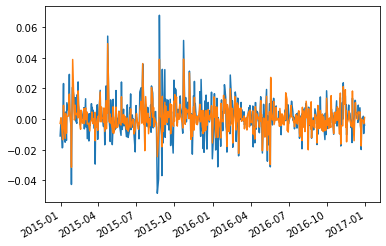

In [ ]:
abnormal_return=fund_return-df_factor.drop(columns=['RF'])@model.params[1:]

fund_return.plot()
abnormal_return.plot()


- How can you produce the abnormal returns more easily simply using outputs from the regression you just run?

- Tip: what regression statistic is equal to the average of the abormal return

Bottom UP

- Now we estimate the factor loadings for each stock
- use our beautiful linear algebra to compute fund exposures



In [ ]:
# estimating Factor Betas
df_factor, df_stocks = df_factor.align(df_stocks, join='inner', axis=0)

Xf = df_factor.drop(columns=['RF'])

B=pd.DataFrame([],index=tickers,columns=Xf.columns)
for ticker in df_stocks.columns:
    y = df_stocks[ticker]
    X = sm.add_constant(Xf)
    X=X[y.isna()==False]
    y=y[y.isna()==False]
    model = sm.OLS(y, X).fit(dropna=True)
    B.loc[ticker,:]=model.params[1:]

B

,Mkt-RF,SMB,HML,RMW,CMA,MOM
AAPL,1.030717,-0.107237,-0.008217,0.763479,-1.460115,-0.030158
GOOGL,0.958094,-0.470574,-0.210335,-0.1177,-1.148522,0.144696
MSFT,1.231883,-0.314873,0.077865,0.656917,-1.120852,0.093478
NVDA,1.2523,0.698145,-0.239075,0.321978,-0.472794,0.165622
AMZN,0.995541,-0.438021,0.05142,-0.267262,-2.001092,0.238466
COST,0.791177,-0.035685,0.006976,0.723471,0.02207,0.207055
WMT,0.77975,-0.139923,-0.256882,0.862723,0.496919,0.106942
TGT,0.863384,0.297708,-0.108899,1.244263,0.541671,0.099742
KR,0.740051,0.048948,-0.026441,0.274185,-0.074022,0.309473


Once we have the Asset betas, then we can compute the fund betas date by date by using the current composition of the portfolio

Obviously this allows you to track the exposure of the fund much better

matters a lot for funds that trade at very high frequency

,Mkt-RF,SMB,HML,RMW,CMA,MOM
date,,,,,,
2014-12-31,1.093707,-0.126512,-0.065668,0.271483,-1.240675,0.122421
2015-01-01,1.093707,-0.126512,-0.065668,0.271483,-1.240675,0.122421
2015-01-02,1.093707,-0.126512,-0.065668,0.271483,-1.240675,0.122421
2015-01-05,1.093707,-0.126512,-0.065668,0.271483,-1.240675,0.122421
2015-01-06,1.093707,-0.126512,-0.065668,0.271483,-1.240675,0.122421
...,...,...,...,...,...,...
2016-12-26,0.793590,0.042762,-0.096312,0.776160,0.246659,0.180803
2016-12-27,0.793590,0.042762,-0.096312,0.776160,0.246659,0.180803
2016-12-28,0.793590,0.042762,-0.096312,0.776160,0.246659,0.180803


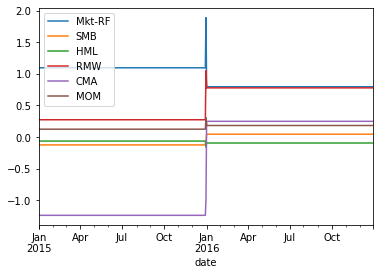

In [ ]:
_temp=final_portfolio_df.merge(B,left_on='ticker',right_index=True,how='left')
Fund_B = _temp.groupby('date').apply(lambda x: pd.Series((x[Xf.columns].values * x['weight'].values.reshape(-1, 1)).sum(axis=0), index=Xf.columns))
Fund_B.plot()
display(Fund_B)

How do we estimate the fund abnormal return with this approach?

Note that there is no reason to believe that the asset betas as stable.

As we discussed, there is a lot of thought in deciding which sample is best to estimate the betas

- Long samples allow for more precision if the true beta is constant
- Shorter samples allow for you to capture time-variation


The general recipe that people use is 1-2 years when using daily data. 5 years when using monthly

## The Cross-Sectional Approach ( or Characteristic-based model)



In the time-series approach, we start from the factors and estimate the betas

Now we will flip this: we will start from the betas--which are the characteristic--and use a regression to tell us what is the return associated with this characteristic

That is, we will estimate the factors themselves!

The time-series approach requires

- factors that are traded
- Need to estimate the time-series beta as a first step for abnormal return construction

The Cross-sectional approach goes directly from characteristics to abnormal returns and is often the preferred choice across quant shops because it allows for very large set of factors

The goal is to estimate the returns associated with a characteristic in a particular date, but do that in a way that does not involve the complicated steps of portfolio formation that are hard to do for many characteristics at the same time

Recipe

1.  Get a large set of excess return for stocks (hopefully all) for a given date, R
2.  Get the characteristics of these same stocks , X for this "date".
  - **Important**: the characteristics should be as of the the date before to avoid a spurious regression
  - it is useful to normalize the characteristics so we can in terms of standard deviations from the  average

3. Run the regression

$$R=BX+\epsilon$$

Note than from the OLS formula--If you have not seen this formula at some point in your life- today is the date!

$$B=(X'X)^{-1}X'R$$


- The B coefficients are excess returns themselves as they are just linear combinations of excess returns, i.e. the betas are portfolio returns
- They are returns on "pure play" portfolios. Portfolios designed to  take a loading of 1 on a charateristic and zero in all the others
- $(X'X)^{-1}X'$ are the weights on the pure play portfolio





In [4]:
url = "https://github.com/amoreira2/Fin418/blob/main/assets/data/characteristics_raw.pkl?raw=true"

df_X = pd.read_pickle(url)
# This simply shits the date to be in an end of month basis


df_X.set_index(['date','permno'],inplace=True)
df_X


#df_X.groupby('permno')['re'].std()*12**0.5

re      rf     rme       size     value      prof  \
date       permno                                                            
2006-01-31 10085   0.025224  0.0035  0.0304  14.132980 -0.775040 -2.223152   
           10104   0.025984  0.0035  0.0304  18.034086 -2.186115 -0.458025   
           10107   0.072982  0.0035  0.0304  19.399144 -1.357207 -1.094087   
           10137   0.095710  0.0035  0.0304  15.226304 -0.256102 -2.418484   
           10138   0.057586  0.0035  0.0304  15.913684 -1.553967 -1.227315   
...                     ...     ...     ...        ...       ...       ...   
2016-12-31 93420   0.011056  0.0003  0.0182  14.337515  1.049163 -2.411521   
           93422  -0.063881  0.0003  0.0182  15.256946  0.829353 -2.489367   
           93423   0.039950  0.0003  0.0182  15.502888 -2.128977 -1.246771   
           93429   0.072124  0.0003  0.0182  15.504722 -3.001095 -0.049507   
           93436   0.127947  0.0003  0.0182  17.262975 -3.328269 -1.793726   

                   fscore  debtiss  repurch     nissa  ...    momrev  \
date       permno                                      ...             
2006-01-31 10085        7        0        1  0.691947  ...  0.527791   
           10104        6        1        1  0.690818  ...  0.111133   
           10107        4        1        1  0.686126  ...  0.133546   
           10137        7        0        0  0.824237  ...  0.295023   
           10138        7        1        1  0.704786  ...  0.213203   
...                   ...      ...      ...       ...  ...       ...   
2016-12-31 93420        3        0        1  0.831315  ... -0.433445   
           93422        4        1        1  0.857435  ... -0.372774   
           93423        6        0        1  0.684617  ...  0.123321   
           93429        7        1        1  0.683359  ...  0.182133   
           93436        2        0        0  0.772211  ... -0.088376   

                     valuem     nissm     strev      ivol   betaarb   indrrev  \
date       permno                                                               
2006-01-31 10085  -0.711504  0.697500 -0.003088  0.003396  1.030378 -0.003491   
           10104  -1.633254  0.687115 -0.030952  0.012757  1.473739 -0.005108   
           10107  -1.725634  0.667695 -0.055275  0.006959  1.166726 -0.029431   
           10137  -0.743060  0.782290  0.137262  0.012228  0.834982  0.124839   
           10138  -1.661273  0.701101  0.005004  0.006970  1.263471 -0.001327   
...                     ...       ...       ...       ...       ...       ...   
2016-12-31 93420  -0.202973  0.992891  0.427073  0.036756  1.817194  0.330914   
           93422  -0.023505  0.856731  0.223398  0.020980  1.445948  0.127239   
           93423  -2.341838  0.694344  0.047260  0.013848  0.872411  0.019069   
           93429  -2.984005  0.686027  0.093973  0.011400  0.738250 -0.054112   
           93436  -2.422126  0.763229 -0.042128  0.018539  1.255059 -0.109353   

                      price       age     shvol  
date       permno                                
2006-01-31 10085   3.569814  5.480639  0.723779  
           10104   2.502255  5.480639  1.007820  
           10107   3.263849  5.480639  0.856907  
           10137   3.454738  6.349139  0.952114  
           10138   4.277083  5.476464  0.605547  
...                     ...       ...       ...  
2016-12-31 93420   2.706048  4.382027  2.598174  
           93422   2.978586  4.369448  1.555136  
           93423   4.054217  4.382027  1.316938  
           93429   4.232656  4.382027  1.210638  
           93436   5.243861  4.382027  1.919764  

[120396 rows x 32 columns]

In [5]:
# lets standardize the data
X_std=(df_X.drop(columns=['re','rf','rme']).groupby('date').transform(lambda x: (x-x.mean())/x.std()))

In [31]:
#Lets start by picking a month
date='2006-09'
X=X_std.loc[date]
R=df_X.loc[date,'re']



# Run the regression
# multiplyin by 100 to get percentage
model = sm.OLS(100*R, X).fit()

# Print the summary of the regression
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                     re   R-squared (uncentered):                   0.158
Model:                            OLS   Adj. R-squared (uncentered):              0.131
Method:                 Least Squares   F-statistic:                              6.017
Date:                Tue, 18 Nov 2025   Prob (F-statistic):                    1.81e-20
Time:                        14:29:41   Log-Likelihood:                         -3128.4
No. Observations:                 962   AIC:                                      6315.
Df Residuals:                     933   BIC:                                      6456.
Df Model:                          29                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**What this means?**

- For example this means that a portfolio that takes one "unit" of the  the size anomaly and zero of everything else had a return in that month of 0.39%

- Value got clobbered with a return of -2.76%

- Because we normalize, it means you have a portfolio that has stocks with 1 standard deviation of the characteristic above the characteristic average in that date


What are the portfolios?

In [35]:
#across lines we have the differnt characteristics and across columns we have the different stocks and their wights to implement the portfolio that is exposed to that chracteristic and nothign else

Characteristic_portfolio_weights=np.linalg.inv(X.T@X)@X.T
Characteristic_portfolio_weights.index=X.columns
Characteristic_portfolio_weights

date      2006-09-30                                                    \
permno         10104     10107     10137     10138     10143     10145   
size        0.002726  0.004360 -0.000686 -0.000294 -0.001032  0.001538   
value      -0.002632  0.006965  0.000676  0.000402  0.001094  0.000918   
prof       -0.004929 -0.005258  0.002034  0.002285 -0.008617  0.002159   
fscore     -0.000836  0.000893 -0.000555 -0.000177  0.002782  0.001506   
debtiss    -0.001236  0.001006 -0.000597  0.000775 -0.000740  0.002011   
repurch     0.000264 -0.001071  0.001303  0.000584  0.002529  0.000491   
nissa      -0.001617  0.000601 -0.000104 -0.000428 -0.002482 -0.000482   
growth      0.002627 -0.002042 -0.001180  0.000641  0.006734  0.001257   
aturnover   0.004871  0.004464 -0.003664 -0.007132  0.007850 -0.000981   
gmargins    0.003855  0.004819 -0.002342 -0.003515  0.005676 -0.002311   
ep          0.000271 -0.000069 -0.000293  0.000143 -0.000826 -0.000250   
sgrowth    -0.000287  0.000121  0.000095 -0.000050  0.001933  0.000055   
lev        -0.001423 -0.001301 -0.001663 -0.005339 -0.005967  0.000626   
roaa        0.001069  0.001812 -0.000686  0.002124 -0.008606 -0.001630   
roea       -0.000707 -0.000298  0.000059 -0.000892  0.002531  0.000550   
sp          0.000065  0.000296 -0.000223  0.002129 -0.000102 -0.000631   
mom         0.003275 -0.001444  0.000414  0.000814  0.004850  0.000500   
indmom     -0.001036 -0.000790  0.001130 -0.000069 -0.000559  0.000744   
mom12      -0.000448 -0.000538  0.000771  0.000531 -0.003858 -0.001458   
momrev     -0.000637 -0.000340  0.002424 -0.000383 -0.004906 -0.000384   
valuem      0.002454 -0.006450 -0.000259  0.000282 -0.000720 -0.001481   
nissm       0.001268 -0.001002  0.000261  0.000340  0.002121  0.000014   
strev       0.001438  0.000856  0.001983 -0.003842 -0.001651 -0.005159   
ivol       -0.000693 -0.000813 -0.000575 -0.000243 -0.000003 -0.000482   
betaarb     0.001033 -0.001787 -0.000101  0.002654  0.001072  0.002249   
indrrev    -0.000593 -0.000945 -0.001676  0.004517  0.003180  0.004748   
price      -0.002615 -0.001900 -0.000078  0.000075  0.001128 -0.000128   
age         0.000211 -0.000759  0.001319  0.000274  0.002850  0.000730   
shvol      -0.000060  0.001666  0.000600 -0.002817  0.002260 -0.001090   

date                                               ...                      \
permno        10147     10182     10225     10299  ...     89702     89753   
size       0.001587 -0.000573  0.000838 -0.000320  ... -0.000651 -0.000082   
value      0.000914  0.001651  0.000402  0.000781  ...  0.002959 -0.001872   
prof      -0.000689 -0.001997  0.003331 -0.006068  ... -0.019083  0.002454   
fscore     0.002053 -0.000181 -0.001518  0.001342  ...  0.000608 -0.000435   
debtiss   -0.001833  0.001377 -0.000026 -0.000127  ...  0.000919  0.000659   
repurch    0.000340 -0.001383 -0.001643 -0.000055  ... -0.000987 -0.001089   
nissa     -0.000480  0.000256 -0.001693  0.000070  ...  0.001202  0.000048   
growth     0.000534  0.000382  0.002447 -0.000216  ... -0.000920 -0.000798   
aturnover  0.000484 -0.008215 -0.003439  0.002336  ...  0.023270 -0.004813   
gmargins   0.000605  0.001060 -0.001483  0.003727  ...  0.011010 -0.002337   
ep        -0.000066  0.006725  0.000147  0.000138  ... -0.000719  0.000504   
sgrowth    0.000081 -0.000231 -0.000377  0.000371  ... -0.000251 -0.000266   
lev       -0.000846 -0.012928 -0.000303 -0.003485  ...  0.002164 -0.002672   
roaa      -0.000170 -0.002489 -0.001095  0.002394  ...  0.000023  0.000402   
roea       0.000388  0.000520  0.000250 -0.000938  ...  0.000191 -0.000201   
sp        -0.000166  0.017161 -0.000159  0.001461  ... -0.002150  0.000303   
mom       -0.000680 -0.001967  0.001638  0.001538  ... -0.000963  0.006294   
indmom     0.001156 -0.000728 -0.003179 -0.000662  ... -0.000162  0.000246   
mom12     -0.000226  0.000581 -0.001932 -0.001952  ... -0.000535 -0.002585   
momrev    -0.000023 -0.001467  0.000014 -0.000539  ...  0.000848 -0

What do we do with this?

1. For a given portfolio I can exactly compute it's charaterestic-adjusted portfolio returns, if I know the portfolio characteristics
2. I can also construct a time-series of return for each characteristic, by simply splicing together the regression coefficients of different dates.
  - Essentially I would run a for loop and get a sequence of betas $[\beta_t,\beta_{t+1},...]$ and these would be the returns on the factors




### Constructing Characteristic adjusted returns


We can get the portfolio characteristics and based on that construct the return implied by these characteristics

We then subtract these characteristic returns from the portfolio returns

It is the equivalent of the "hedged portfolios" that uses the betas to hedge. Here we simply use the characterisitc--instead of makign "factor" neutral we make them characteristic neutral


In [9]:
# Step 1: construct 2 portfolios 1 and 2 ( tech and retail)

portfolio_data1 = {'port': [1,1,1,1,1],
    'ticker': ['AAPL', 'GOOG', 'MSFT','NVDA','AMZN'],
    'weight': [0.2,0.2, 0.2,0.2,0.2]
}

portfolio_data2 = {'port': [2,2,2,2],
    'ticker': ['COST', 'WMT', 'TGT','KR'],
    'weight': [0.25,0.25, 0.25,0.25]
}

portfolio_df1 = pd.DataFrame(portfolio_data1)
portfolio_df2 = pd.DataFrame(portfolio_data2)
portfolio_df = pd.concat([portfolio_df1, portfolio_df2], ignore_index=True)
print(portfolio_df)




   port ticker  weight
0     1   AAPL    0.20
1     1   GOOG    0.20
2     1   MSFT    0.20
3     1   NVDA    0.20
4     1   AMZN    0.20
5     2   COST    0.25
6     2    WMT    0.25
7     2    TGT    0.25
8     2     KR    0.25


In [10]:
# Step 2: Get the permnos associated with these ticker so we can do the matching
# our data has permnos, not tickers
#conn=wrds.Connection()
# get the pemnos for the tickers
permno=get_permnos(portfolio_df.ticker.unique(),conn)

permno['namedt'] = pd.to_datetime(permno['namedt'])
permno['nameenddt'] = pd.to_datetime(permno['nameenddt'])

date='2008-03'
d = pd.to_datetime(date)
# note that sometimes the pernmo changes!
# so we need to get the permnos that are valid at the relevant date
permno_d=permno[(permno['nameenddt']>=d) & (permno['namedt']<=d)]

portfolio_df=portfolio_df.merge(permno_d[['permno','ticker']],on='ticker',how='left')
portfolio_df

,port,ticker,weight,permno
0,1,AAPL,0.20,14593
1,1,GOOG,0.20,90319
2,1,MSFT,0.20,10107
3,1,NVDA,0.20,86580
4,1,AMZN,0.20,84788
5,2,COST,0.25,87055
6,2,WMT,0.25,55976
7,2,TGT,0.25,49154
8,2,KR,0.25,16678


In [11]:
# Step 3: merge our portfolio with our main data set that contains returns and characterisitc
# here we are doign just for one date. Of course you can also do for multiple dates.
#IF the portfolios are fixed that is trivial. If the portfolio is changing , then you should have two identifiers for your
#portfolio in step 1 "port" and "date"


X=X_std.loc[date].reset_index()
port_stocks_X=portfolio_df.merge(X,left_on='permno',right_on='permno',how='left')
port_stocks_X



,port,ticker,weight,permno,date,size,value,prof,fscore,debtiss,...,momrev,valuem,nissm,strev,ivol,betaarb,indrrev,price,age,shvol
0,1,AAPL,0.20,14593,2008-03-31,2.410205,-1.315480,0.455224,-0.091077,1.303219,...,0.575718,-1.421058,0.147848,-0.580727,0.330686,0.752957,-0.868990,1.888114,0.398208,2.904418
1,1,GOOG,0.20,90319,2008-03-31,2.528013,-1.118659,0.564933,-0.091077,1.303219,...,0.755154,-1.005315,0.229125,-1.402481,0.158169,-0.694430,-1.224557,3.959159,-2.339689,1.693268
2,1,MSFT,0.20,10107,2008-03-31,3.257090,-1.363239,0.985259,0.755457,1.303219,...,0.726842,-1.531135,-0.438239,-1.377024,-0.637930,-0.456596,-1.195484,-0.492776,0.105671,-0.399737
3,1,NVDA,0.20,86580,2008-03-31,0.680226,-1.634531,0.817117,0.755457,1.303219,...,1.172971,-0.842731,0.223491,-1.079041,1.603828,2.812533,-1.183732,-0.867861,-1.084778,1.545659
4,1,AMZN,0.20,84788,2008-03-31,1.240524,-3.728875,1.118980,-0.091077,1.303219,...,1.249185,-3.528315,0.034269,-1.451173,0.544068,1.264655,-1.341326,0.854323,-0.858657,1.347997
5,2,COST,0.25,87055,2008-03-31,1.154301,0.138992,0.785716,-0.091077,-0.766462,...,-0.499439,-0.268807,-0.301382,-0.674229,-0.579135,-0.414050,-0.454017,0.791327,0.126212,0.223698
6,2,WMT,0.25,55976,2008-03-31,2.960595,-0.322603,1.029022,-0.937610,-0.766462,...,-0.424544,-0.260600,-0.348921,-0.082608,-1.065065,-0.802397,0.221643,0.444707,0.753804,-1.140483
7,2,TGT,0.25,49154,2008-03-31,1.815796,-0.209013,0.909948,1.601991,-0.766462,...,0.974779,-0.055104,-0.423087,-0.319158,0.450388,0.077535,-0.048508,0.536987,0.871398,0.443988
8,2,KR,0.25,16678,2008-03-31,0.934108,-0.149013,1.326149,0.755457,-0.766462,...,-0.172023,-0.295956,-0.406029,-0.282320,-0.487468,-0.728124,-0.006437,-0.671970,1.220560,-0.344465


Now we can compute each portfolio characteristic

In [12]:
# step 4: finally we simply average the characteristics within each portfolio
# we now know how value, momentum, and so on is our portfolio as a funciton of what they hold

X_names=X.drop(columns=['permno','date']).columns
port_X=port_stocks_X.groupby('port').apply(lambda x: x['weight'] @ x[X_names])
port_X

/tmp/ipython-input-939177059.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  port_X=port_stocks_X.groupby('port').apply(lambda x: x['weight'] @ x[X_names])


weight,size,value,prof,fscore,debtiss,repurch,nissa,growth,aturnover,gmargins,...,momrev,valuem,nissm,strev,ivol,betaarb,indrrev,price,age,shvol
port,,,,,,,,,,,,,,,,,,,,,
1,2.023212,-1.832157,0.788303,0.247537,1.303219,0.202595,-0.021355,0.558931,0.525197,0.320116,...,0.895974,-1.665711,0.039299,-1.178089,0.399764,0.735824,-1.162818,1.068192,-0.755849,1.418321
2,1.716200,-0.135409,1.012709,0.332190,-0.766462,0.642131,-0.272052,-0.261772,1.427599,-0.806162,...,-0.030307,-0.220117,-0.369855,-0.339578,-0.420320,-0.466759,-0.071830,0.275263,0.742994,-0.204316


We can then compute the portfolio "characteristic-implied" returns and the portfolio characteristic-adjusted return

In [13]:
# Step 5:  estimate the return associated with each characteristic  using the entire investment universe
# we already this step above, but I am repeating here for completeness
# you eould have to repeat this procedure date by data if doign that for multiple dates

X=X_std.loc[date]
R=df_X.loc[date,'re']

# Run the regression
model = sm.OLS(R, X).fit()

R_X=model.params
R_X

,0
size,-0.008685
value,0.010048
prof,0.014476
fscore,-0.000212
debtiss,-0.009435
repurch,0.008764
nissa,0.007878
growth,0.001369
aturnover,-0.026765
gmargins,-0.011491


In [14]:

# Step6: compute the charateteristic implied returns by using the portfolio chanrateristics to compute the portfolio returns
#implied by these characteristics. This the equivalent of $\sum \beta f_{t}^i$, but here port_X are the "betas"
# and R_X and the factors--the returns associated with the charateristic

port_characteristic_returns=port_X[X_names] @R_X
print(port_characteristic_returns)

port
1   -0.027497
2    0.006339
dtype: float64


In [18]:
# step 7: Subtract the charateristic implied return from the portfolio return to obtain the charateristic-adjsuted retrun
# this is the equivalent of $R^{port}_t-\sum \beta f_{t}^i$

# portfolio  raw excess return
_temp=portfolio_df.merge(R.reset_index(),left_on='permno',right_on='permno')
R_port=_temp.groupby('port').apply(lambda x: x['weight']@ x['re'])
display('raw returns')
print(R_port)
display('Characteristic-based returns')
print(port_characteristic_returns)
#  characteristic-adjsuted
Port_characteristic_adjsuted_returns=R_port-port_characteristic_returns
display('Characteristic-adjusted returns')
print(Port_characteristic_adjsuted_returns)

/tmp/ipython-input-2696903702.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  R_port=_temp.groupby('port').apply(lambda x: x['weight']@ x['re'])


'raw returns'

port
1    0.029733
2    0.030074
dtype: float64


'Characteristic-based returns'

port
1   -0.027497
2    0.006339
dtype: float64


'Characteristic-adjusted returns'

port
1    0.057230
2    0.023735
dtype: float64


Why practitioners like this?

- You don't need the time-series betas and all the issues with the size of the sample and how they might move around
- All you need is the characteristic at a given date, and that characteristic can move around a lot as we estimate date by date
- We used no time-series data at all
- You can have very large number of factors: can add sector/industry factors, country factors, currency factors, you name it. Just add to your regression



What are the issues?

- The main issue is that ignores covariances, so the characteristic-adjusted portfolios are characteristic neutral but not factor neutral
   - For example: a stock might be large but co-move with small stocks and not large stocks, a stock might be classified as retail but co-move with tech
   - of course we only care about the characteristics because they describe movement in returns
   - But this might or might not be true and we re almost certain that it will be suboptimal
   - Now as the number of characteristics grow and they describe returns better and better, this becomes less of an issue
   - Consistent with the industry practice of have large set of characteristics (often north of 50-100)

- Another issue is that this approach will tend to load on small stocks
    - Basically the OLS tries to fit all data points equally and most stocks are tiny
    - One fix is to use Weighted-Least Squares where you put more weight on larger firms
    - or simply estimate your characteristic returns eliminating the smallest stocks--say focus on the top 20% by market cap




---
##📝 Key Takeaways

- **Multi-factor models are the industry work-horse.**  They capture multiple rewarded risks simultaneously, delivering more realistic benchmarks and richer performance attribution.    

- **Alpha is scarce; beta is plentiful.**  Time-series regressions on standard factors reveal that most “smart-beta” ETFs provide factor exposure, not out-performance—true skill shows up only in the intercept.    

- **Variance decomposition sharpens intuition.**  Viewing risk as a weighted blend of factor volatilities highlights which exposures dominate and where diversification gains remain.    

- **Factor-based covariance matrices are stabler and more tractable.**  Using a handful of factors plus idiosyncratic terms avoids the noise that plagues full empirical covariances, improving minimum-variance and risk-parity constructions.    

- **Risk changes with allocation tilts, not just position size.**  A small weight shift toward a fund with similar betas barely moves portfolio volatility, while the same shift toward a factor-orthogonal fund can raise risk sharply.    

- **Bottom-up attribution excels for high-turnover managers.**  Refreshing exposures at the holding level avoids the lag and instability that afflict purely return-based estimates.    

- **Characteristic models broaden the toolkit but ignore covariances.**  They neutralize portfolios on observed attributes quickly and at scale, yet leave hidden co-movement risks untouched—reminding practitioners that factor and characteristic views are complements, not substitutes.  


---
